In [1]:
import pandas as pd

In [2]:
training_set_labels=pd.read_csv(r'C:\Users\Admin\OneDrive\Desktop\Coursework\semester 4\MLPR\MLPR_project\data\training_set_labels.csv')
training_set_values=pd.read_csv(r'C:\Users\Admin\OneDrive\Desktop\Coursework\semester 4\MLPR\MLPR_project\data\traning_set_values.csv') 

Train_data = pd.merge(training_set_values, training_set_labels, on='id')
df_training=Train_data.copy()

test_set_values = pd.read_csv(r'C:\Users\Admin\OneDrive\Desktop\Coursework\semester 4\MLPR\MLPR_project\data\test_set_values.csv')


### Label Encoding original

In [3]:
import numpy as np
import pandas as pd  # <-- Missing import
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Columns to drop
duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                     'waterpoint_type', 'payment_type', 'quality', 'recorded_by']
crossed_out_columns = duplicate_columns + ['date_recorded']

#------------------------------------------------
# 1. Preprocessing + Label Encoding
#------------------------------------------------

def assign_raininess(month):
    if month in [3, 4, 5]:
        return 4
    elif month in [10, 11, 12]:
        return 3
    elif month in [1, 2]:
        return 2
    else:
        return 1

categorical_cols = []
encoders = {}

def clean_encode_label(df, is_train=True):
    global categorical_cols, encoders

    if 'date_recorded' in df.columns: 
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(assign_raininess)
        df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')

    for col in df.select_dtypes(include='object').columns:
        if is_train and col == 'status_group':
            continue
        df[col].fillna("other", inplace=True)

    df.fillna(0, inplace=True)

    if is_train:
        categorical_cols = [col for col in df.select_dtypes(include='object').columns if col != 'status_group']
        encoders = {}

        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))  # Fixed typo: fit_trainsform → fit_transform
            encoders[col] = le
    else:
        for col in categorical_cols:
            if col in df.columns:
                le = encoders[col]  # Reuse the encoder from training
                col_data = df[col].astype(str)
                col_data[~col_data.isin(le.classes_)] = le.classes_[0]  # Fixed: inin → isin
                df[col] = le.transform(col_data)

    return df

#------------------------------------------------
# 2. Model Training 
#------------------------------------------------

def build_model_label(train_df, data_proportion=1.0, n_estimators=550, max_depth=None, random_state=42):
    train_df = clean_encode_label(train_df, is_train=True)
    y = train_df['status_group']
    X = train_df.drop(columns=['status_group'])

    if data_proportion < 1.0:
        X, _, y, _ = train_test_split(X, y, train_size=data_proportion, stratify=y, random_state=random_state)  # Fixed: random_stare → random_state

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Model trained on {data_proportion*100:.1f}% of the data")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return {
        'model': model
    }

# -----------------------------
# 3. Prediction Function
# -----------------------------

def predict_test_set_label(model_data, test_df):
    test_df_cleaned = clean_encode_label(test_df, is_train=False)
    model = model_data['model']

    predictions = model.predict(test_df_cleaned)

    result_df = pd.DataFrame({
        'id': test_df['id'] if 'id' in test_df.columns else test_df.index,
        'status_group': predictions
    })

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"predictions_{timestamp}.csv"
    result_df.to_csv(filename, index=False)
    print(f"✅ Saved {len(result_df)} predictions to {filename}")

    return result_df


C:\Users\Admin\AppData\Local\Temp\ipykernel_14952\3362664595.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("other", inplace=True)


Model trained on 1.0% of the data
Accuracy: 0.8067
Classification Report:
                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85        65
functional needs repair       0.50      0.12      0.20         8
         non functional       0.84      0.78      0.81        46

               accuracy                           0.81       119
              macro avg       0.71      0.61      0.62       119
           weighted avg       0.79      0.81      0.79       119



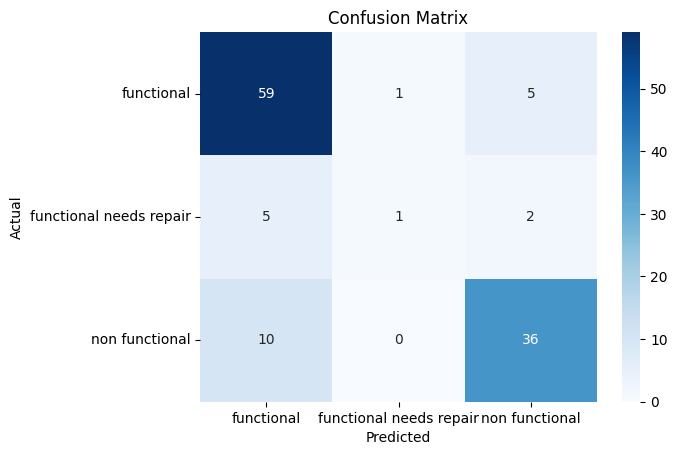

{'model': RandomForestClassifier(random_state=42)}

In [7]:
build_model_label(df_training, 0.01, 100)

### k-fold target encoding

In [6]:
k=250

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Columns to drop
duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                     'waterpoint_type', 'payment_type', 'quality', 'recorded_by']
crossed_out_columns = duplicate_columns + ['date_recorded']

# Set the number of folds (can be adjusted)
k_folds = k  # Default value of 5, you can change this based on your preference

# --------------------------------------
# 1. Preprocessing + K-Fold Target Encoding
# --------------------------------------

def assign_raininess(month):
    if month in [3, 4, 5]:
        return 4
    elif month in [10, 11, 12]:
        return 3
    elif month in [1, 2]:
        return 2
    else:
        return 1

categorical_cols = []
target_encoding_maps = {}

def kfold_target_encode_multiclass(df, categorical_cols, target_col, n_splits=k_folds, random_state=42):
    df_encoded = df.copy()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    global target_encoding_maps
    target_encoding_maps = {}

    for col in categorical_cols:
        class_probs = np.zeros((df.shape[0], df[target_col].nunique()))
        for train_idx, val_idx in kf.split(df):
            train_fold, val_fold = df.iloc[train_idx], df.iloc[val_idx]
            probs = train_fold.groupby(col)[target_col].value_counts(normalize=True).unstack().fillna(0)

            for i, target_class in enumerate(sorted(df[target_col].unique())):
                val_map = val_fold[col].map(probs[target_class]).fillna(probs[target_class].mean())
                class_probs[val_idx, i] = val_map

        for i, target_class in enumerate(sorted(df[target_col].unique())):
            df_encoded[f"{col}_te_{target_class}"] = class_probs[:, i]

        df_encoded.drop(columns=col, inplace=True)
        target_encoding_maps[col] = probs  # Save for test-time encoding

    return df_encoded

def apply_target_encoding_to_test(test_df, categorical_cols, target_col='status_group'):
    df_encoded = test_df.copy()

    for col in categorical_cols:
        probs = target_encoding_maps.get(col)
        if probs is None:
            continue
        for target_class in probs.columns:
            df_encoded[f"{col}_te_{target_class}"] = (
                df_encoded[col].map(probs[target_class]).fillna(probs[target_class].mean())
            )
        df_encoded.drop(columns=col, inplace=True)

    return df_encoded

def clean_encode_target(df, is_train=True):
    global categorical_cols

    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(assign_raininess)
        df = df.drop(columns=[col for col in crossed_out_columns if col in df.columns], errors='ignore')

    for col in df.select_dtypes(include='object').columns:
        if is_train and col == 'status_group':
            continue
        df[col].fillna("other", inplace=True)

    df.fillna(0, inplace=True)

    if is_train:
        categorical_cols = [col for col in df.select_dtypes(include='object').columns if col != 'status_group']
        df = kfold_target_encode_multiclass(df, categorical_cols, 'status_group', n_splits=k_folds)
    else:
        df = apply_target_encoding_to_test(df, categorical_cols, 'status_group')

    return df

# --------------------------------------
# 2. Model Training
# --------------------------------------

def build_model_target(train_df, data_proportion=1.0, n_estimators=550, max_depth=None, random_state=42):
    train_df = clean_encode_target(train_df, is_train=True)
    y = train_df['status_group']
    X = train_df.drop(columns=['status_group'])

    if data_proportion < 1.0:
        X, _, y, _ = train_test_split(X, y, train_size=data_proportion, stratify=y, random_state=random_state)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Model trained on {data_proportion*100:.1f}% of the data")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return {'model': model}

# --------------------------------------
# 3. Prediction Function
# --------------------------------------

def predict_test_set_target(model_data, test_df):
    test_df_cleaned = clean_encode_target(test_df, is_train=False)
    model = model_data['model']

    predictions = model.predict(test_df_cleaned)

    result_df = pd.DataFrame({
        'id': test_df['id'] if 'id' in test_df.columns else test_df.index,
        'status_group': predictions
    })

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"latest_predictions_{timestamp}.csv"
    result_df.to_csv(filename, index=False)
    print(f"✅ Saved {len(result_df)} predictions to {filename}")

    return result_df


C:\Users\Admin\AppData\Local\Temp\ipykernel_23976\1563194423.py:87: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("other", inplace=True)


Model trained on 100.0% of the data
Accuracy: 0.8354
Classification Report:
                         precision    recall  f1-score   support

             functional       0.81      0.94      0.87      6452
functional needs repair       0.76      0.35      0.48       863
         non functional       0.89      0.78      0.83      4565

               accuracy                           0.84     11880
              macro avg       0.82      0.69      0.73     11880
           weighted avg       0.84      0.84      0.83     11880



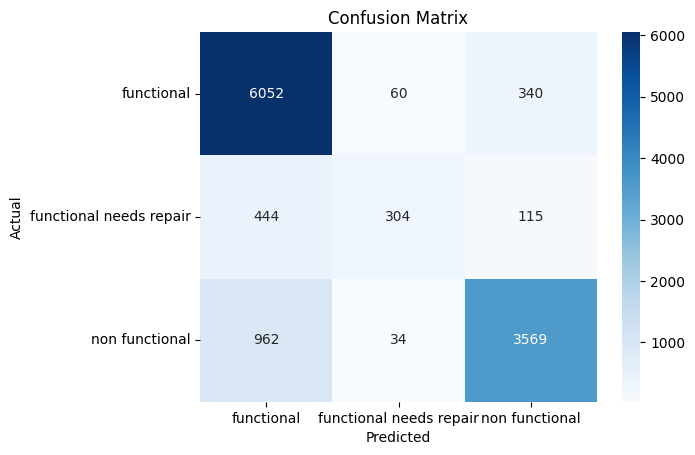

In [8]:
model_data = build_model_target(df_training, data_proportion=1, n_estimators=400, max_depth=None, random_state=42)


In [41]:
predict_test_set_target(model_data, test_set_values)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14952\1563194423.py:87: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("other", inplace=True)


✅ Saved 14850 predictions to latest_predictions_2025-05-14_12-45-39.csv


,id,status_group
0,50785,non functional
1,51630,functional
2,17168,non functional
3,45559,non functional
4,49871,functional
...,...,...
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional


### plotting all the categorical values with categories less that 20.

In [4]:
df = training_set_values.copy()

In [5]:
string_cols_df= df.select_dtypes(include = 'object')

In [6]:
string_cols_df.columns

Index(['date_recorded', 'funder', 'installer', 'wpt_name', 'basin',
       'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

In [7]:
unique_count = training_set_values['payment'].value_counts()
len(unique_count)

7

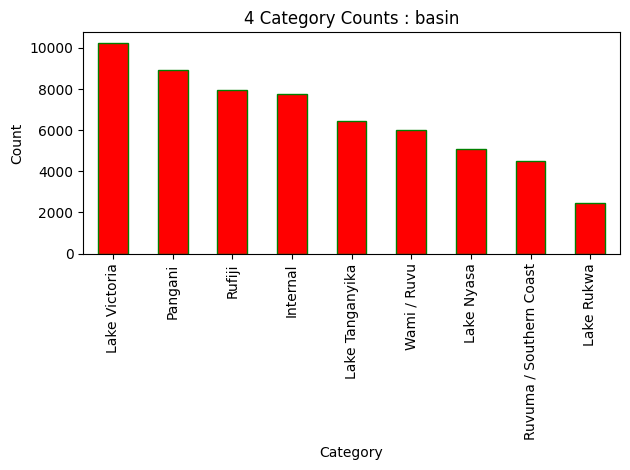

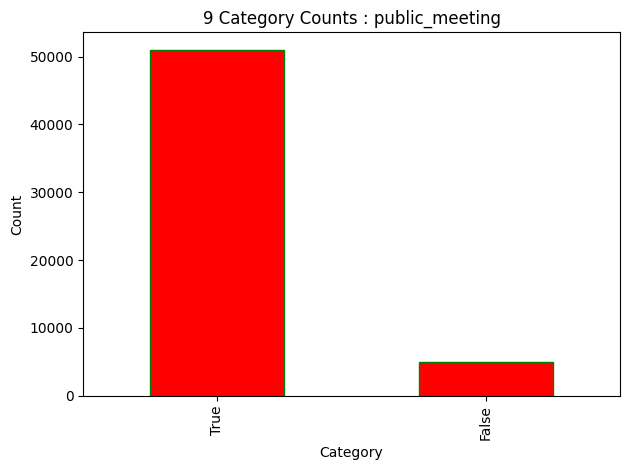

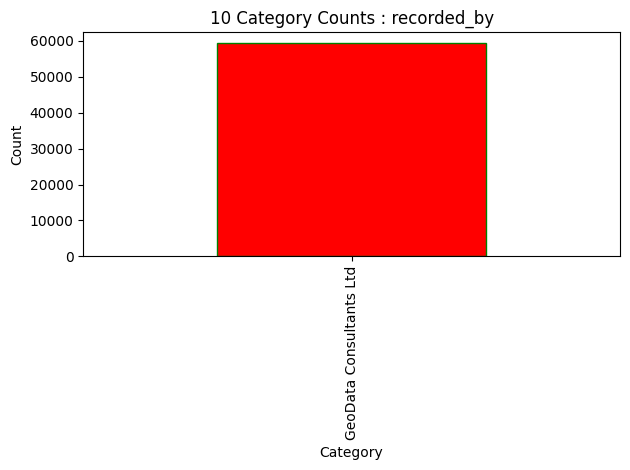

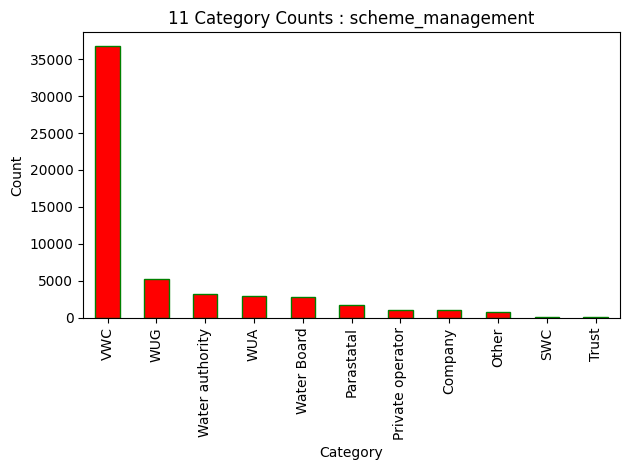

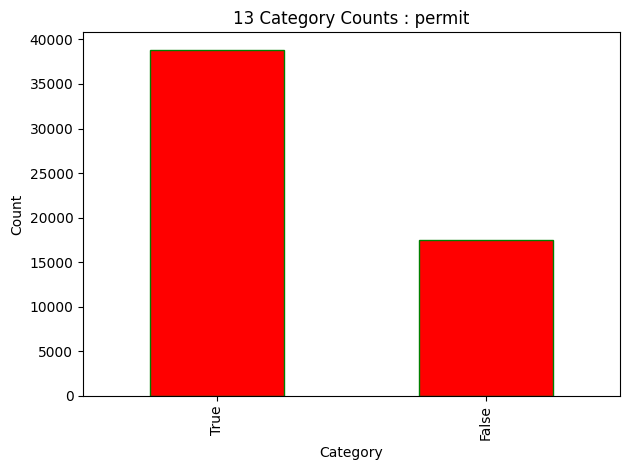

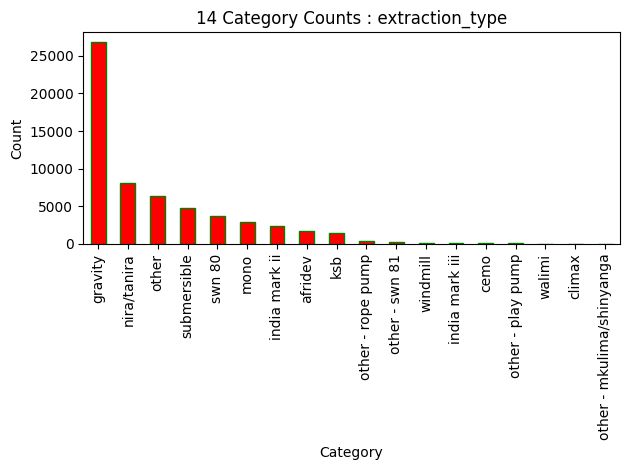

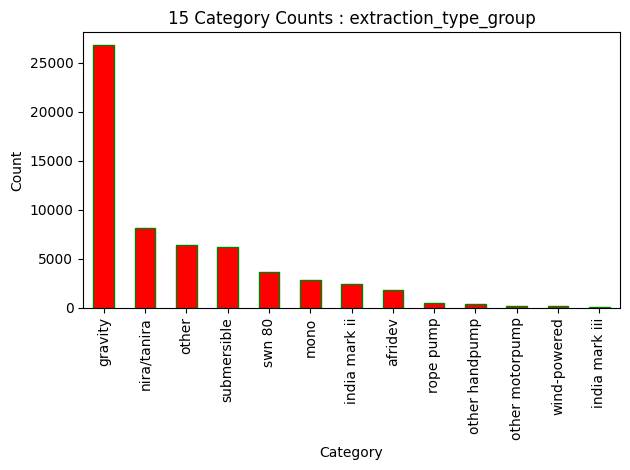

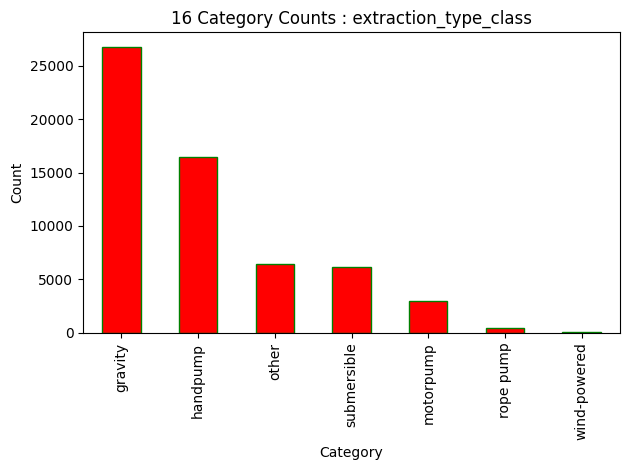

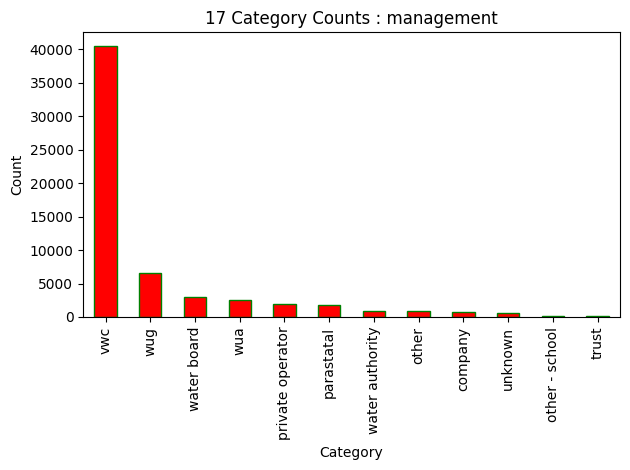

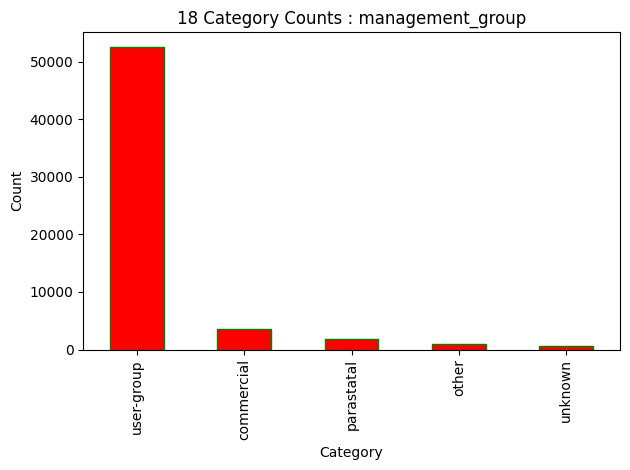

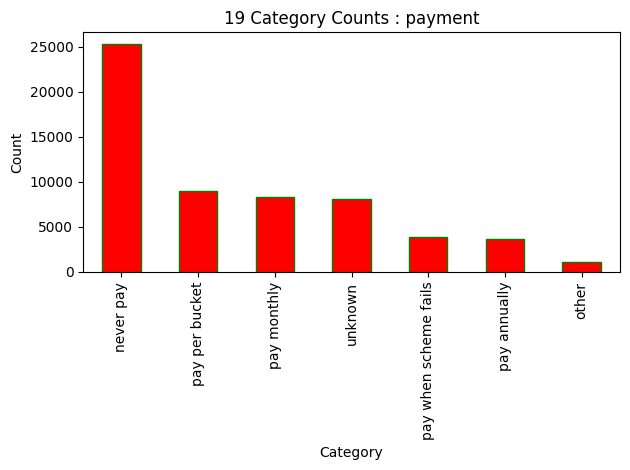

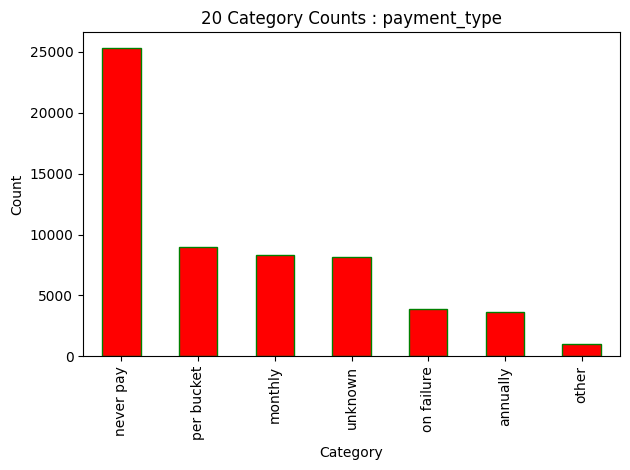

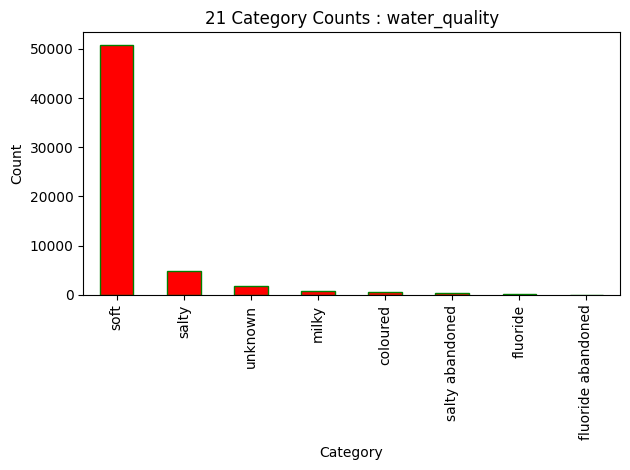

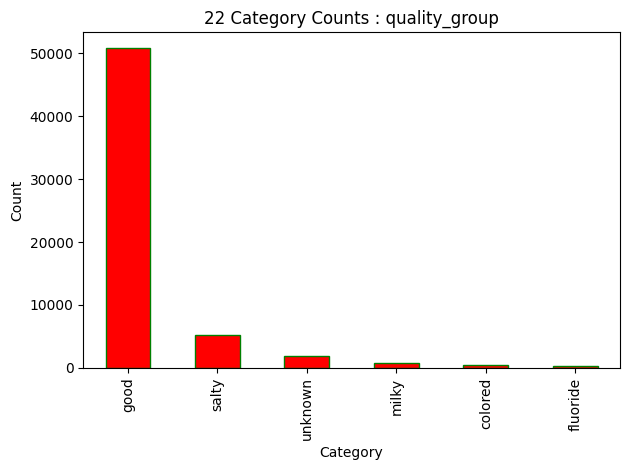

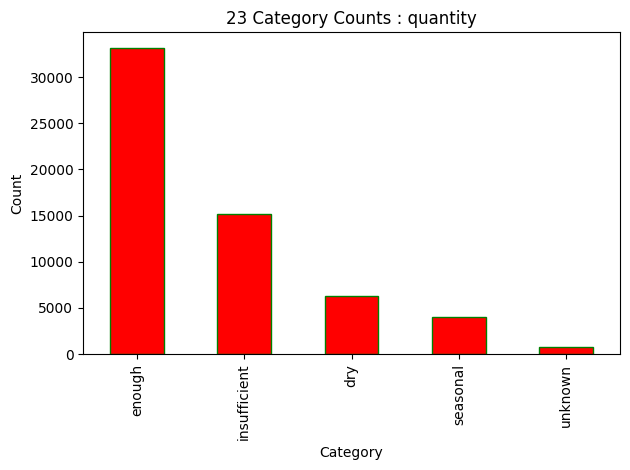

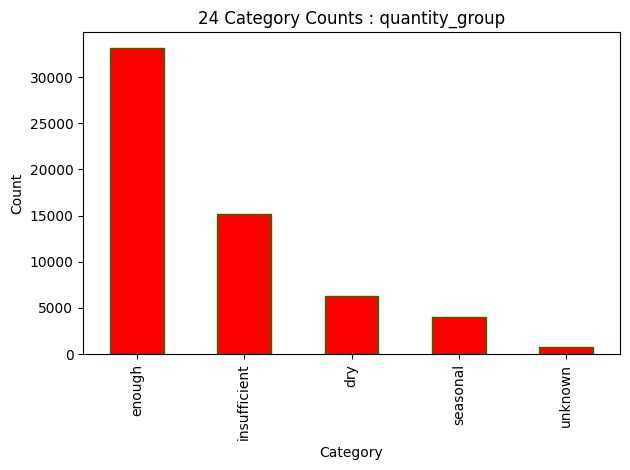

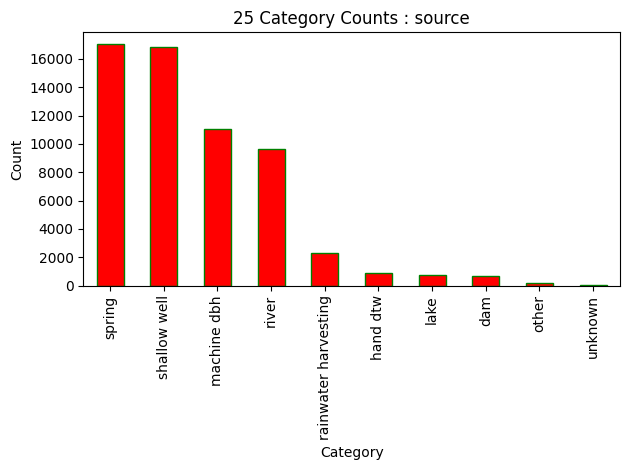

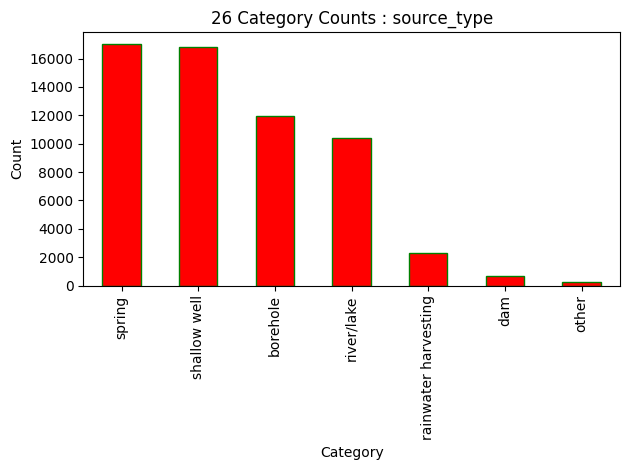

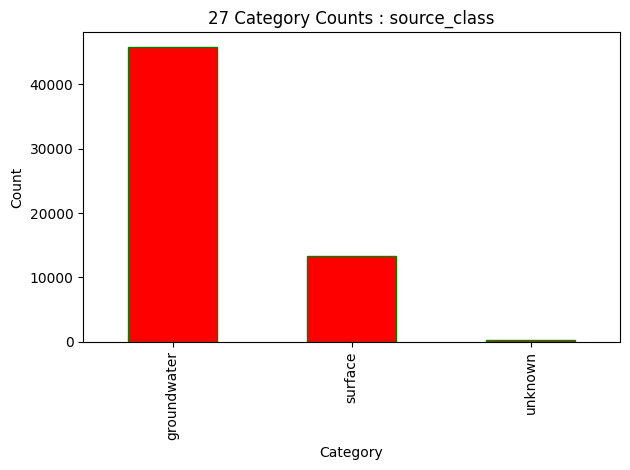

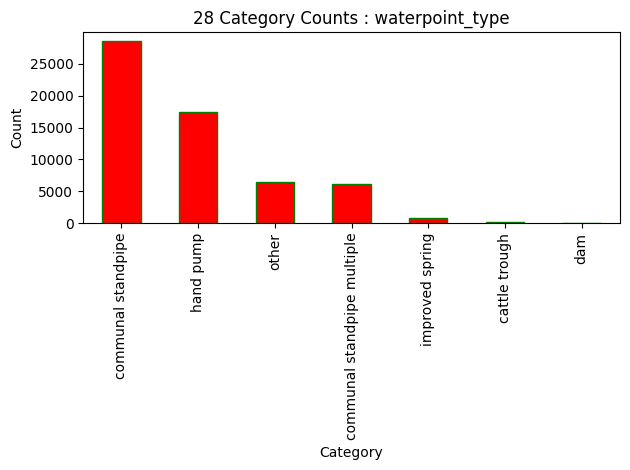

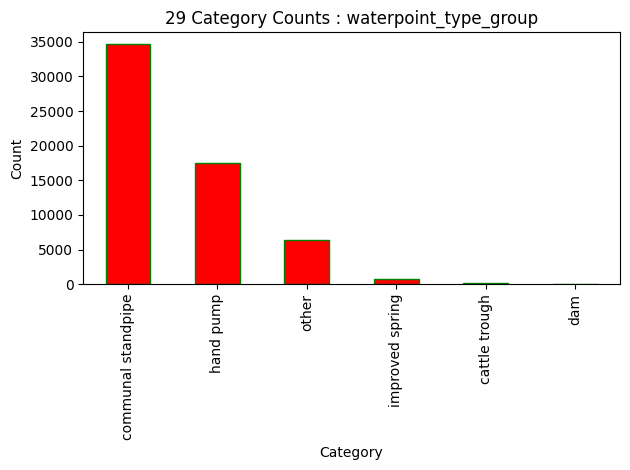

In [ ]:
# for i, col in enumerate(string_cols_df.columns): 
#     unique_count = training_set_values[col].value_counts()
#     if len(unique_count)<20:
#         unique_count.plot(kind = 'bar', color= 'red', edgecolor = 'green')
#         plt.title(f'{i} Category Counts : {col}')
#         plt.xlabel('Category')
#         plt.ylabel('Count')
#         plt.xticks(rotation=90)
#         plt.tight_layout()
#         plt.show()



### catboost

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier, Pool

# Columns to drop
duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                     'waterpoint_type', 'payment_type', 'quality', 'recorded_by']
crossed_out_columns = duplicate_columns + ['date_recorded']


# ------------------------------
# 1. Preprocessing
# ------------------------------
def assign_raininess(month):
    if month in [3, 4, 5]:
        return 4
    elif month in [10, 11, 12]:
        return 3
    elif month in [1, 2]:
        return 2
    else:
        return 1


def clean_data_catboost(df, is_train=True):
    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(assign_raininess)
        df.drop(columns=[col for col in crossed_out_columns if col in df.columns], inplace=True)

    for col in df.select_dtypes(include='object').columns:
        if is_train and col == 'status_group':
            continue
        df[col].fillna("other", inplace=True)

    df.fillna(0, inplace=True)

    return df


# ------------------------------
# 2. Model Training with CatBoost
# ------------------------------
def build_model_catboost(train_df, data_proportion=1.0, iterations=300, learning_rate=0.05, depth=None, random_state=42):
    df = clean_data_catboost(train_df, is_train=True)

    y = df['status_group']
    X = df.drop(columns=['status_group'])

    # Identify categorical features
    cat_features = X.select_dtypes(include='object').columns.tolist()

    # Reduce training size if needed
    if data_proportion < 1.0:
        X, _, y, _ = train_test_split(X, y, train_size=data_proportion, stratify=y, random_state=random_state)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

    train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

    model = CatBoostClassifier(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        loss_function='MultiClass',
        eval_metric='Accuracy',
        verbose=100,
        random_seed=random_state
    )

    model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

    y_pred = model.predict(X_test).flatten()

    print(f"Model trained on {data_proportion*100:.1f}% of the data")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return {'model': model, 'cat_features': cat_features}


# ------------------------------
# 3. Prediction Function
# ------------------------------
def predict_test_set_catboost(model_data, test_df):
    model = model_data['model']
    cat_features = model_data['cat_features']

    test_clean = clean_data_catboost(test_df, is_train=False)

    test_pool = Pool(data=test_clean, cat_features=cat_features)
    predictions = model.predict(test_pool).flatten()

    result_df = pd.DataFrame({
        'id': test_df['id'] if 'id' in test_df.columns else test_df.index,
        'status_group': predictions
    })

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"catboost_predictions_{timestamp}.csv"
    result_df.to_csv(filename, index=False)
    print(f"✅ Saved {len(result_df)} predictions to {filename}")

    return result_df


C:\Users\Admin\AppData\Local\Temp\ipykernel_24984\1087116759.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("other", inplace=True)


0:	learn: 0.7216961	test: 0.7280303	best: 0.7280303 (0)	total: 604ms	remaining: 3m
100:	learn: 0.7783880	test: 0.7895623	best: 0.7898990 (91)	total: 48.6s	remaining: 1m 35s
200:	learn: 0.7882576	test: 0.7941919	best: 0.7944444 (176)	total: 1m 36s	remaining: 47.5s
299:	learn: 0.7930556	test: 0.8007576	best: 0.8010943 (293)	total: 2m 29s	remaining: 0us

bestTest = 0.8010942761
bestIteration = 293

Shrink model to first 294 iterations.
Model trained on 100000.0% of the data
Accuracy: 0.8011
Classification Report:
                         precision    recall  f1-score   support

             functional       0.79      0.91      0.84      6452
functional needs repair       0.61      0.24      0.35       863
         non functional       0.84      0.76      0.80      4565

               accuracy                           0.80     11880
              macro avg       0.75      0.64      0.66     11880
           weighted avg       0.80      0.80      0.79     11880



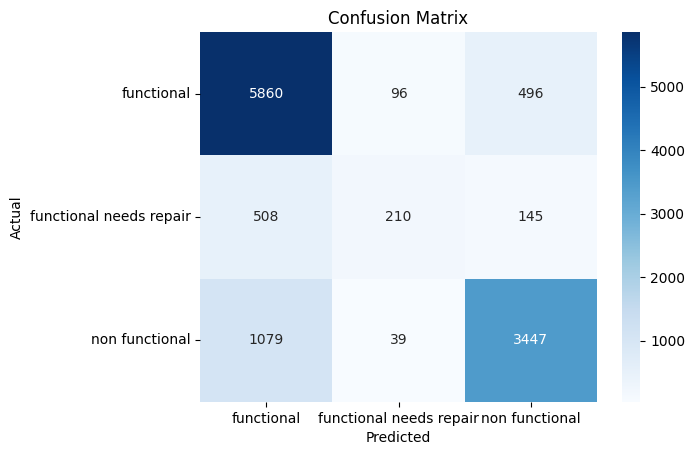

{'model': <catboost.core.CatBoostClassifier at 0x232c519eb30>,
 'cat_features': ['funder',
  'installer',
  'basin',
  'subvillage',
  'region',
  'lga',
  'ward',
  'public_meeting',
  'scheme_management',
  'scheme_name',
  'permit',
  'extraction_type_group',
  'extraction_type_class',
  'management',
  'management_group',
  'payment',
  'quality_group',
  'quantity',
  'quantity_group',
  'source_type',
  'source_class',
  'waterpoint_type_group']}

In [20]:
build_model_catboost(df_training,1000)

#### catboost + optuna

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from catboost import CatBoostClassifier, Pool

# ------------------------------
# 1. Preprocessing
# ------------------------------
duplicate_columns = ['wpt_name', 'extraction_type', 'source', 'water_quality',
                     'waterpoint_type', 'payment_type', 'quality', 'recorded_by']
crossed_out_columns = duplicate_columns + ['date_recorded']

def assign_raininess(month):
    if month in [3, 4, 5]:
        return 4
    elif month in [10, 11, 12]:
        return 3
    elif month in [1, 2]:
        return 2
    else:
        return 1

def clean_data_catboost(df, is_train=True):
    if 'date_recorded' in df.columns:
        df['date_recorded'] = pd.to_datetime(df['date_recorded'])
        df['raininess_score'] = df['date_recorded'].dt.month.apply(assign_raininess)
        df.drop(columns=[col for col in crossed_out_columns if col in df.columns], inplace=True)

    for col in df.select_dtypes(include='object').columns:
        if is_train and col == 'status_group':
            continue
        df[col].fillna("other", inplace=True)

    df.fillna(0, inplace=True)
    return df

# ------------------------------
# 2. Optuna Objective Function
# ------------------------------
def objective(trial, train_df):
    df = clean_data_catboost(train_df)
    y = df['status_group']
    X = df.drop(columns=['status_group'])

    cat_features = X.select_dtypes(include='object').columns.tolist()

    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)

    model = CatBoostClassifier(
        iterations=trial.suggest_int('iterations', 100, 1000),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
        depth=trial.suggest_int('depth', 4, 10),
        l2_leaf_reg=trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        loss_function='MultiClass',
        eval_metric='Accuracy',
        verbose=0,
        random_seed=42
    )

    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=0)

    preds = model.predict(X_valid).flatten()
    acc = accuracy_score(y_valid, preds)
    return acc

# ------------------------------
# 3. Run Optuna and Train Final Model
# ------------------------------
def optimize_and_train(train_df, n_trials=30):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, train_df), n_trials=n_trials)

    print("✅ Best hyperparameters:", study.best_params)

    # Train best model on full train set
    df = clean_data_catboost(train_df)
    y = df['status_group']
    X = df.drop(columns=['status_group'])

    cat_features = X.select_dtypes(include='object').columns.tolist()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    test_pool = Pool(X_test, y_test, cat_features=cat_features)

    best_model = CatBoostClassifier(
        **study.best_params,
        loss_function='MultiClass',
        eval_metric='Accuracy',
        verbose=100,
        random_seed=42
    )

    best_model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

    y_pred = best_model.predict(X_test).flatten()

    print(f"\n📊 Final Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=best_model.classes_, yticklabels=best_model.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return {'model': best_model, 'cat_features': cat_features}


# ------------------------------
# 4. Prediction Function
# ------------------------------
def predict_test_set_catboost(model_data, test_df):
    model = model_data['model']
    cat_features = model_data['cat_features']

    test_clean = clean_data_catboost(test_df, is_train=False)

    test_pool = Pool(data=test_clean, cat_features=cat_features)
    predictions = model.predict(test_pool).flatten()

    result_df = pd.DataFrame({
        'id': test_df['id'] if 'id' in test_df.columns else test_df.index,
        'status_group': predictions
    })

    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"catboost_predictions_{timestamp}.csv"
    result_df.to_csv(filename, index=False)
    print(f"✅ Saved {len(result_df)} predictions to {filename}")

    return result_df


C:\Users\Admin\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
# Run hyperparameter search and train best model
model_data = optimize_and_train(df_training, n_trials=50)



[I 2025-05-14 16:16:02,913] A new study created in memory with name: no-name-2f669f3a-15c4-4d7a-9630-e6ce935f595a
C:\Users\Admin\AppData\Local\Temp\ipykernel_24984\1734538225.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna("other", inplace=True)
[I 2025-05-14 16:18:53,209] Trial 0 finished with value: 0.8053872053872054 and parameters: {'iterations': 428, 'learning_rate': 0.1647629191542583, 'depth': 5, 'l2_leaf_reg': 9.655454295978714}. Best is trial 0 with value: 0.8053872053872054.
C:\Users\Admin\AppData

KeyboardInterrupt: 